In [1]:
# from __future__ import print_function, division
import torchvision
from torchvision import transforms
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import time
import os.path
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from skimage import io
import glob
import os
import os.path
import copy

from lodgingdataset import LodgingDataset
import tsfm
from deeplant_utils import show_numpy_images, show_tensor_images

In [2]:
data_dir = "."
train_dir = os.path.join(data_dir, "training_canola_2016")
test_dir = os.path.join(data_dir, "test_canola_2016")

dataset_mean = [0.485, 0.456, 0.406, 0.456, 0.406]
dataset_std = [0.229, 0.224, 0.225, 0.224, 0.225]

In [3]:
# Define tranfsformation for the training data
train_transform = tsfm.Compose([tsfm.Rescale(110, anti_aliasing=True, mode='constant'),
                                tsfm.RandomHorizontalFlip(),
#                                       transforms.RandomRotation(10, expand=True),
                                tsfm.RandomCrop(96),
                                tsfm.ToTensor(),
                                transforms.Normalize(mean=dataset_mean,
                                                     std=dataset_std)])
# Define tranfsformation for the test data
test_transform = transforms.Compose([tsfm.Rescale(110,anti_aliasing=True, mode='constant'),
                                     tsfm.RandomCrop(96),
                                     tsfm.ToTensor(),
                                     transforms.Normalize(mean=dataset_mean,
                                                          std=dataset_std)])

trget_transform = tsfm.LabelToTensor()

# Get all data for training; this include validation data too
training_data =  LodgingDataset(train_dir, file_name_pattern='.png',
                                transform=train_transform,
                                target_transform=trget_transform)


In [4]:
# split the training data to two datasets train_dataset and valid_dataset
random_indices = np.random.permutation(len(training_data))
train_ratio, valid_ratio = 0.80, 0.20
n = int(train_ratio*len(training_data))
train_indices = random_indices[:n]
valid_indices = random_indices[n:]

train_dataset = torch.utils.data.Subset(training_data, train_indices)
valid_dataset = torch.utils.data.Subset(training_data, valid_indices)

# get test dataset
test_dataset =  LodgingDataset(test_dir, file_name_pattern='.png',
                               transform=test_transform,
                               target_transform = trget_transform)

In [5]:
batch_size = 8
dataloaders = {}

dataloaders["train"] = torch.utils.data.DataLoader(train_dataset,
                                                   shuffle=True,
                                                   batch_size=batch_size,
                                                   num_workers=1)

dataloaders["valid"] = torch.utils.data.DataLoader(valid_dataset,
                                                   shuffle=True,
                                                   batch_size=batch_size,
                                                   num_workers=1)

dataloaders["test"] = torch.utils.data.DataLoader(test_dataset,
                                                  shuffle=False,
                                                  batch_size=batch_size,
                                                  num_workers=1)

dataset_sizes = {"train": len(train_dataset),
                 "valid":len(valid_dataset),
                 "test":len(test_dataset)}

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1_1 = nn.Conv2d(5, 32, 3, padding=1)
        self.conv1_2 = nn.Conv2d(32, 32, 3, padding=1)
        self.conv2_1 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv2_2 = nn.Conv2d(64, 64, 3, padding=1)
        self.fc_1 = nn.Linear(24 * 24 * 64, 128)
        self.fc_2 = nn.Linear(128, 2)

    def forward(self, x):
        x = F.relu(self.conv1_1(x))
        x = F.relu(self.conv1_2(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2_1(x))
        x = F.relu(self.conv2_2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 24 * 24 * 64)
        x = F.relu(self.fc_1(x))
        return self.fc_2(x)


# Building the network
model_ft = Model()
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
# optimizer_ft = optim.SGD(fc.parameters(), lr=0.001, momentum=0.9)
optimizer_ft = optim.Adam(model_ft.parameters())
# Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft,
#                                              step_size=10,
#                                              gamma=0.9)

In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        print(".", end="", sep="")
        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
#                 scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                print(".", sep='', end='')
                inputs = inputs.to(device, dtype=torch.float)
                labels = labels.to(device, dtype=torch.int64)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [8]:
model_ft = train_model(model_ft, criterion, optimizer_ft, scheduler=None, num_epochs=50)

Epoch 0/49
----------
.....................................................................................................................................train Loss: 0.2164 Acc: 0.9183
.................................valid Loss: 0.0694 Acc: 0.9735

Epoch 1/49
----------
.....................................................................................................................................train Loss: 0.0701 Acc: 0.9782
.................................valid Loss: 0.0651 Acc: 0.9886

Epoch 2/49
----------
.....................................................................................................................................train Loss: 0.0723 Acc: 0.9820
.................................valid Loss: 0.0629 Acc: 0.9811

Epoch 3/49
----------
.....................................................................................................................................train Loss: 0.0574 Acc: 0.9858
.................................valid Loss: 0.0465 Acc: 0.98

.....................................................................................................................................train Loss: 0.0105 Acc: 0.9953
.................................valid Loss: 0.0069 Acc: 0.9962

Epoch 33/49
----------
.....................................................................................................................................train Loss: 0.0397 Acc: 0.9877
.................................valid Loss: 0.0089 Acc: 0.9962

Epoch 34/49
----------
.....................................................................................................................................train Loss: 0.0257 Acc: 0.9924
.................................valid Loss: 0.0034 Acc: 1.0000

Epoch 35/49
----------
.....................................................................................................................................train Loss: 0.0196 Acc: 0.9915
.................................valid Loss: 0.0033 Acc: 1.0000

Epoch 36/49
---

In [9]:
os.mkdir("models")

In [10]:
torch.save(model_ft.state_dict(), "models/01.Main-Architecture.pth")

In [12]:
correct = 0
total = 0
loss = 0
y_pred = []
y_true = []

with torch.no_grad():
    for data in dataloaders["test"]:
        images, labels = data
#         inputs = inputs.to(device, dtype=torch.float)
#         labels = labels.to(device, dtype=torch.int64)
        images = images.to(device, dtype=torch.float)
        labels = labels.to(device, dtype=torch.int64)
        outputs = model_ft(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        test_loss = criterion(outputs, labels)
        
        y_pred += predicted.to("cpu").detach().numpy().tolist()
        y_true += labels.to("cpu").detach().numpy().tolist()
        
print('Test accuracy: {:.4f}' .format( 100 * correct / total))
print('Test Loss: %.4f'%(test_loss))

Test accuracy: 99.0654
Test Loss: 0.0001


Confusion Matrix
[[ 91   2]
 [  1 227]]


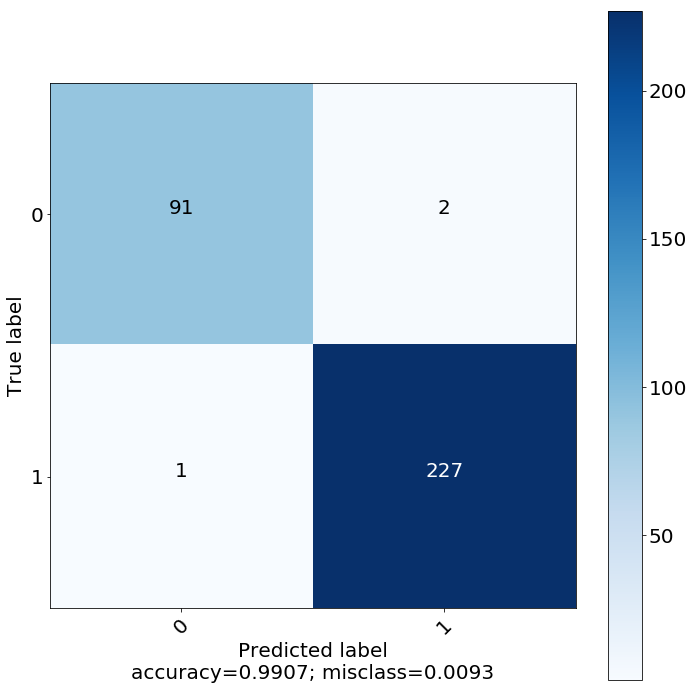

In [13]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)

   
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.savefig('plots/3.InceptionV3-2-Private-DataSet-CM.png', bbox_inches='tight', dpi = 100) 
plt.figure(figsize=(10,10))

labels = ['0', '1']

plot_confusion_matrix(cm, classes=labels,
                      title='Confusion Matrix')

In [14]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
classnames=[]
for classname in dataloaders["test"]:
    classnames.append(classname)

confusion_mtx = confusion_matrix(y_true, y_pred) 
print(confusion_mtx)
target_names = classnames
# print(classification_report(y_true, y_pred, target_names=target_names))
print(classification_report(y_true, y_pred))

[[ 91   2]
 [  1 227]]
              precision    recall  f1-score   support

           0       0.99      0.98      0.98        93
           1       0.99      1.00      0.99       228

   micro avg       0.99      0.99      0.99       321
   macro avg       0.99      0.99      0.99       321
weighted avg       0.99      0.99      0.99       321



In [15]:
total=sum(sum(cm))

accuracy = (cm[0,0]+cm[1,1]) / total
print ('Accuracy : ', accuracy*100)

sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity*100 )

Specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', Specificity*100 )

Accuracy :  99.06542056074767
Sensitivity :  98.91304347826086
Specificity :  99.12663755458514
